# Assigment 2

## The assignment is divided into programming and mathematical questions. Both of them are given in this notebook.

## Programming questions: I am giving you a template that you can use to write your code. Description of the questions is integrated in the comments.

## Upload your code on Learn dropbox and submit pdfs of the code and answers to the mathematical questions on Crowdmark.

## -----------------------------------------------------------------------------------------------------------

## Load modules

In [117]:
# !pip install numpy, scipy, scikit-image, skimage, matplotlib

import matplotlib.pyplot as plt

from skimage.color import rgb2gray
from skimage import data
from skimage.transform import resize

# Numpy is useful for handling arrays and matrices.
import numpy as np

## Load image

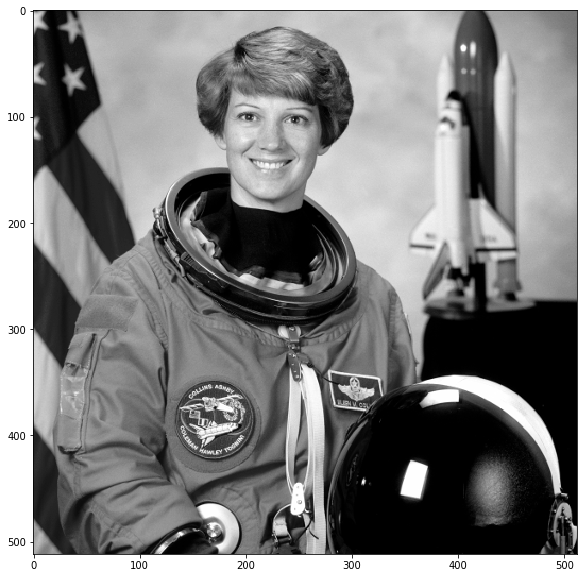

In [118]:
img = data.astronaut()
img = rgb2gray(img)*255 # convert to gray and change scale from (0,1) to (0,255).

n = img.shape[0]

plt.figure(1, figsize=(10, 10))
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.show()

## Compute the differences operators here. Use your code from Assignment 1.

In [119]:
# You will need these three methods to construct sparse differences operators.
# If you do not use sparse operators you might have scalability problems.
from scipy.sparse import diags
from scipy.sparse import kron
from scipy.sparse import identity

# Use your code from Assignment 1. 
# Make sure that you compute the right D_h and D_v matrices.
diagonals = ([-1],[1])
j = diags(diagonals, [0,1], shape=(n,n), format=None, dtype=int)
i = np.identity(n, int)
d_h = kron(j,i)
d_v = kron(i,j)

## Add noise to the image

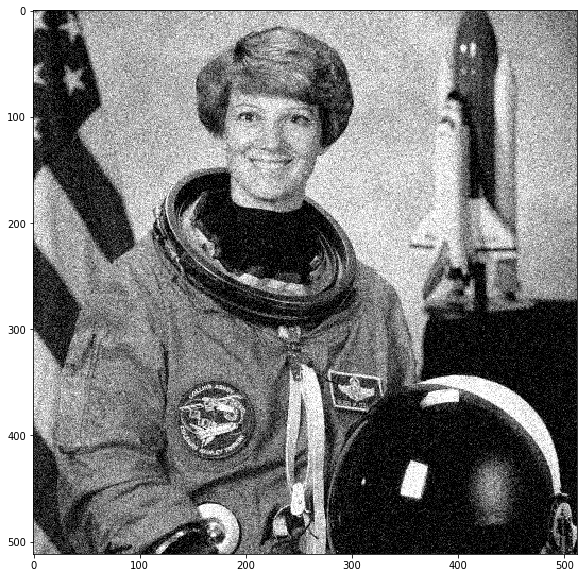

In [120]:
mean_ = 0
standard_deviation = 30
dimensions = (n,n)

noise = np.random.normal(mean_,standard_deviation,dimensions)

noisy_image = img + noise

plt.figure(1, figsize=(10, 10))
plt.imshow(noisy_image, cmap='gray', vmin=0, vmax=255)
plt.show()

## Question 1: implement gradient descent using the Lipschitz constant as the step-size for the denoising problem. Use eigsh method from scipy.sparse.linalg to compute the Lipschitz constant. Marks: 10

In [121]:
from scipy.sparse.linalg import eigsh
from scipy import real
from numpy.linalg import norm

def gradient_descent(x0, epsilon, lambda_, max_iterations):
    
# x0: is the initial guess for the x variables
# epsilon: is the termination tolerance parameter
# lambda_: is the regularization parameter of the denoising problem.
# max_iterations: is the maximum number of iterations that you allow the algorithm to run.

# Write your code here.
    #calculate L
    re_D = d_h.transpose().dot(d_h)+d_v.transpose().dot(d_v)
    D_i = identity(n*n)
    D_2 = lambda_*re_D+D_i
    A = D_2.transpose().dot(D_2)
    largest_val = eigsh(A, k=1, which='LM', return_eigenvectors=False) #largest eigenvalue
#     print(largest_val) [1088.98015996]
    
    #hardcoded the value of L to save run time
#     largest_val = 1088.98015996
    L = math.sqrt(largest_val)
#     print(L)
    D = d_h + 1j * d_v
    D_star = D.conjugate().transpose()
    #gradient descent
    list_x = []
    x_k = x0
    list_x.append(x_k)
    i = 0
    f_der = der_f(x_k, D, D_star, x0) #initial step
#     print(f_der)
    while i < max_iterations:
        if norm(f_der, 2) <= epsilon: break
        x_k = x_k - 1/L * f_der 
#         print(x_k)
        list_x.append(x_k)
        f_der = der_f(x_k, D, D_star, x0)
        i+=1
        
    print("iterations: "+str(i))
    return list_x

def der_f(x, D, D_star, x0):
    return lambda_ * real(D_star.dot(D.dot(x))) + x - x0 #matrix vector product first
    

## Call Gradient Descent

In [122]:
import time
# Initialize parameters of gradient descent.
lambda_ = 4
epsilon = 1.0e-2
max_iterations = 2000

# Set x0 equal to the vectorized noisy image.
# Write your code here.
start = time.time()
z = noisy_image.flatten('F')
list_x = gradient_descent(z, epsilon, lambda_, max_iterations)
end = time.time()
duration = end - start
print("running time: "+str(duration))

iterations: 357
running time: 156.00433611869812


## Plot $$(f(x_k) - f(x^*)) / (f(x_0) - f(x^*))$$ vs the iteration counter k, where $$x^*$$ is the minimizer of the denoising problem, which you can compute by using spsolve, similarly to Assignment 1.

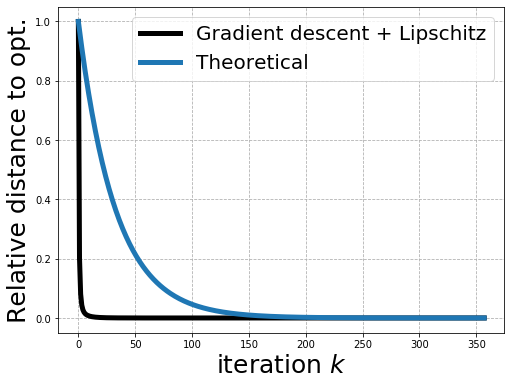

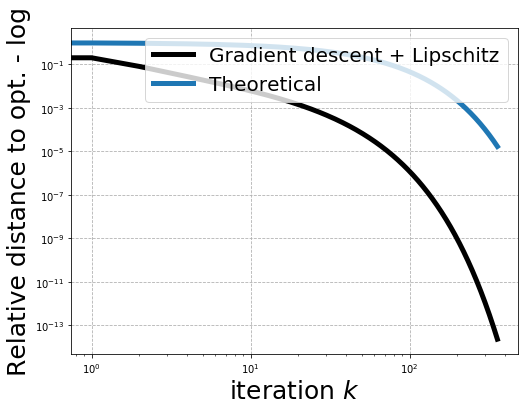

In [123]:
# Plot the rellative objective function vs number of iterations. 
from scipy.sparse.linalg import spsolve

# Write your code here.
def denoise_function(x):
    return lambda_ / 2 * norm(D.dot(x), 2)**2 + 1/2*norm(x-z, 2)**2

D_i = identity(n*n)
D = d_h + 1j * d_v
re_D = d_h.transpose().dot(d_h)+d_v.transpose().dot(d_v)
secondorder_f = lambda_ * re_D + D_i
x_star = spsolve(secondorder_f, z) #z is x0
f_star = denoise_function(x_star)
f_zero = denoise_function(z)

data = []
denominator = f_zero - f_star
for xk in list_x:
    data.append((denoise_function(xk) - f_star) / denominator)

# Here is an example code 

fig = plt.figure(figsize=(8, 6))
plt.plot(data, label=("Gradient descent + Lipschitz"), linewidth=5.0, color ="black")
plt.plot([(1-1/32.999699392) ** x for x in range(len(data))], label=("Theoretical"), linewidth=5.0)

plt.legend(prop={'size': 20},loc="upper right")
plt.xlabel("iteration $k$", fontsize=25)
plt.ylabel("Relative distance to opt.", fontsize=25)
plt.grid(linestyle='dashed')

fig = plt.figure(figsize=(8, 6))
plt.loglog(data, label=("Gradient descent + Lipschitz"), linewidth=5.0, color ="black")
plt.loglog([(1-1/32.999699392) ** x for x in range(len(data))], label=("Theoretical"), linewidth=5.0)

plt.legend(prop={'size': 20},loc="upper right")
plt.xlabel("iteration $k$", fontsize=25)
plt.ylabel("Relative distance to opt. - log", fontsize=25)
plt.grid(linestyle='dashed')
plt.show()
    

## Question 2: is there a "gap" between the practical convergence rate and the theoretical convergence rate? Note that the denoising objective function is strongly convex. Marks: 5

Yes, as you can see from the graph demonstration above. The gap is probably due to the theoretical convergence leaning towards the worst-case scenario.

## Question 3: implement gradient descent with line-search for the denoising problem. Marks: 15

In [124]:
# Write a line-search function here. 
# I am giving you a hint about what the input could be, but feel free to change the template. 
def line_search(x, f_der, a):

# a is alpha

# Write your code here.
    x_step = x - a*f_der
    f_step = denoise_function(x_step) #f_k+!
    f_k = denoise_function(x)
    if f_step < f_k: return x_step #progress inequality is satisfied
    else: 
        a /= 2
        return line_search(x, f_der, a)

# Write gradient descent + line-search here.
# I am giving you a hint about what the input could be, but feel free to change the template. 
def gradient_descent(x0, epsilon, lambda_, max_iterations):

# x0: is the initial guess for the x variables
# epsilon: is the termination tolerance parameter
# lambda_: is the regularization parameter of the denoising problem.
# max_iterations: is the maximum number of iterations that you allow the algorithm to run.

# Write your code here.
    D = d_h + 1j * d_v
    D_star = D.conjugate().transpose()
    
    list_x = []
    x_k = x0
    list_x.append(x_k)
    
#     Dx = D.dot(x_k)
#     grad_reg = norm(Dx, 2)**2
#     grad_fit = norm(x_k-x0, 2)**2
    
    i = 0
    f_der = der_f(x_k, D, D_star, x0) #initial step
    while i < max_iterations:
        if norm(f_der, 2) <= epsilon: break
    
        x_k = line_search(x_k, f_der, 1)

        list_x.append(x_k)
        f_der = der_f(x_k, D, D_star, x0)
#         Dx = D.dot(x_k)
#         grad_reg = norm(Dx, 2)**2
#         grad_fit = norm(x_k-x0, 2)**2
        i+=1
        
    print("iterations: "+str(i))
    return list_x

## Call Gradient Descent with line-search

In [125]:
import time 
# Initialize parameters of gradient descent
lambda_ = 4
epsilon = 1.0e-2
max_iterations = 2000

# Set x0 equal to the vectorized noisy image.
# Write your code here.
start = time.time()
list_x = gradient_descent(z, epsilon, lambda_, max_iterations)
end = time.time()
runningtime = end-start
print("running time: "+str(runningtime))

iterations: 91
running time: 7.7748637199401855


## Plot $$(f(x_k) - f(x^*)) / (f(x_0) - f(x^*))$$ vs the iteration counter k, where $$x^*$$ is the minimizer of the denoising problem, which you can compute by using spsolve, similarly to Assignment 1.

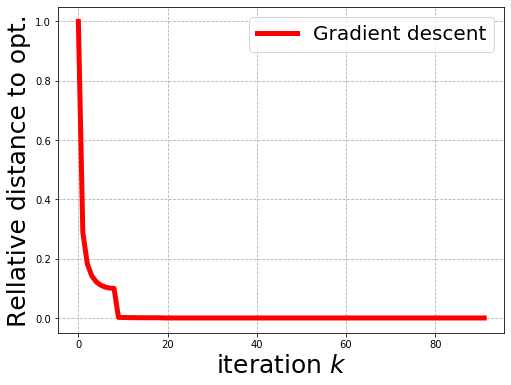

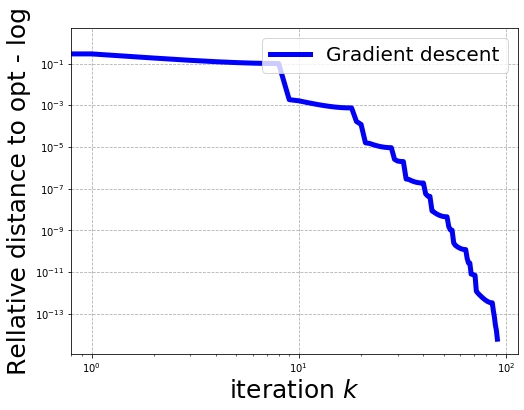

In [126]:
# Plot the rellative objective function vs number of iterations. 

# Write your code here.
data = []
for xk in list_x:
    data.append((denoise_function(xk) - f_star) / denominator)

# Here is an example code 

fig = plt.figure(figsize=(8, 6))
plt.plot(data, label=("Gradient descent"), linewidth=5.0, color ="red")

plt.legend(prop={'size': 20},loc="upper right")
plt.xlabel("iteration $k$", fontsize=25)
plt.ylabel("Rellative distance to opt.", fontsize=25)
plt.grid(linestyle='dashed')

fig = plt.figure(figsize=(8, 6))
plt.loglog(data, label=("Gradient descent"), linewidth=5.0, color ="blue")
plt.legend(prop={'size': 20},loc="upper right")
plt.xlabel("iteration $k$", fontsize=25)
plt.ylabel("Rellative distance to opt - log", fontsize=25)
plt.grid(linestyle='dashed')

plt.show()

## Question 4: What is the advantage of using line-search to compute the step-size at each iteration instead of using constant step-sizes equal to 1/L? Where L is the Lipschitz constant. Is gradient descent with line-search faster than gradient descent with constant step-sizes in terms of running time? Is gradient descent with line-search faster than gradient descent with constant step-sizes in terms of running time when you add computation of the Lipschitz constant in the running time? Is gradient descent with line-search faster than gradient descent with constant step-sizes in terms of number of required iterations? Marks: 10

When you use constant step size equal to 1/L, the learning rate for the gradient descent may be too fast or too slow.
If it is too fast, you may skip the true local minimum. On the other hand, if it is too slow, you are never going to 
converge because you are trying too hard to find the local minimum since the step size are so small. This is the disadvantage of using constant step sizes. The learning rate cannot change and adapt when needed. For instance, a changing learning rate will slow down when the error starts to decrease. This is the benefit of using the line-search. The line search assures that the step sizes are neither too long or too short (using the termination criterion). If step sizes are too long, you may accidentally skip the true local minimum. if step sizes are too small, you will never converge (take too long).
As you can see from one test run, gradient descent using constant step-size 1/L is much slower than gradient descent 
using vanilla line search in terms of both running time (around 156.00 versus 7.77 respectively) and number of required iterations (k=357 versus k=91 respectively).

## Questions 5: implement gradient descent with Armijo line-search for the denoising problem. Marks: 10

In [127]:
# Create a line-search function
def line_search_armijo(x, f_der, a, gamma):

# Write your code here.
    x_step = x - a*f_der 
    f_step = denoise_function(x_step) #f_k+!
    f_k_minus_grad = denoise_function(x) - a*gamma*norm(f_der, 2)**2 #slide 29, lecture 4
    if f_step < f_k_minus_grad: return x_step #progress inequality is satisfied
    else: 
        a /= 2
        return line_search_armijo(x, f_der, a, gamma)

def gradient_descent(x0, epsilon, lambda_, max_iterations, gamma):

# x0: is the initial guess for the x variables
# epsilon: is the termination tolerance parameter
# lambda_: is the regularization parameter of the denoising problem.
# max_iterations: is the maximum number of iterations that you allow the algorithm to run.
# gamma: parameter of Armijo line-search as was defined in the lectures.

# Write your code here.
    D = d_h + 1j * d_v
    D_star = D.conjugate().transpose()
    
    list_x = []
    x_k = x0
    list_x.append(x_k)
    
    i = 0
    f_der = der_f(x_k, D, D_star, x0) #initial step
    while i < max_iterations:
        if norm(f_der, 2) <= epsilon: break
    
        x_k = line_search_armijo(x_k, f_der, 1, gamma)

        list_x.append(x_k)
        f_der = der_f(x_k, D, D_star, x0)
        i+=1
        
    print("iterations: "+str(i))
    return list_x

## Call Gradient Descent with Armijo line search

In [128]:
import time
# Initialize parameters of gradient descent
lambda_ = 4
epsilon = 1.0e-2
max_iterations = 2000
gamma = 0.5

# Set x0 equal to the vectorized noisy image.
# Write your code here.
start = time.time()
list_x = gradient_descent(z, epsilon, lambda_, max_iterations, gamma)
end = time.time()
duration = end-start
print("running time: "+str(duration))

iterations: 93
running time: 7.105585336685181


## Plot $$(f(x_k) - f(x^*)) / (f(x_0) - f(x^*))$$ vs the iteration counter k, where $$x^*$$ is the minimizer of the denoising problem, which you can compute by using spsolve, similarly to Assignment 1.

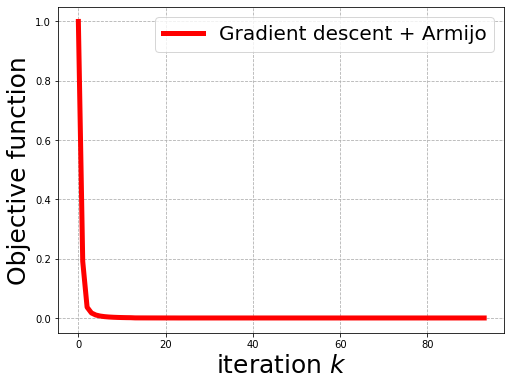

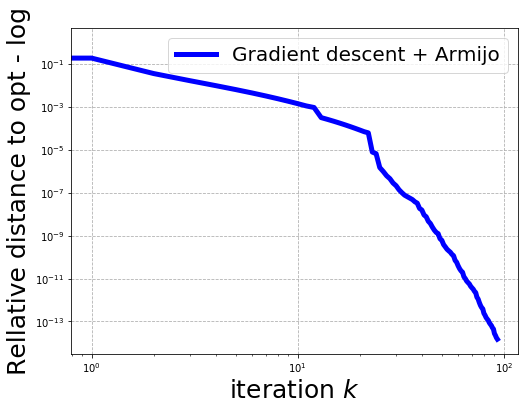

In [129]:
# Plot the rellative objective function vs number of iterations. 

# Write your code here.
data = []
for xk in list_x:
    data.append((denoise_function(xk) - f_star) / denominator)

# Here is an example code 

fig = plt.figure(figsize=(8, 6))
plt.plot(data, label=("Gradient descent + Armijo"), linewidth=5.0, color ="red")

plt.legend(prop={'size': 20},loc="upper right")
plt.xlabel("iteration $k$", fontsize=25)
plt.ylabel("Objective function", fontsize=25)
plt.grid(linestyle='dashed')

fig = plt.figure(figsize=(8, 6))
plt.loglog(data, label=("Gradient descent + Armijo"), linewidth=5.0, color ="blue")
plt.legend(prop={'size': 20},loc="upper right")
plt.xlabel("iteration $k$", fontsize=25)
plt.ylabel("Rellative distance to opt - log", fontsize=25)
plt.grid(linestyle='dashed')
plt.show()

## Question 6: Is gradient descent with Armijo line-search faster than gradient descent with simple line-search in terms of running time? Is gradient descent with Armijo line-search faster than gradient descent with simple line-search in terms of number of required iterations? Explain any performance differences between the two approaches. Marks: 10

They are similarly for this problem. But, technically, Armijo is faster. For example, in one run, the running time using Armijo line search is around 7.10 while using simple line search, it is 7.77. Similarly, for required iterations, k=93 for Armijo and k=91 for simple line search in one run. 
Both method prevents steps from getting too small and steps that are too long/big relative to the decrease in the objective function. Armijo has a stricter termination criterion. When comparing the graphs from the vanilla versus the Armijo line search, we can see that the curve is steeper for Armijo; Armijo converges faster.
However, Armijo has about the same iterations as vanilla line search (2 more) because the termination criterion is based on the norm of the gradient and not the objective function. The objective function always decreases but the norm of the gradient is not monotonic (it may go up or down, probably due to the second order derivative)

## Mathematical Questions

## Question 7: prove that the denoising objective function is strongly convex. What is its strong convexity parameter? Marks: 5

## Question 8: Prove that Armijo line-search will terminate after a finite number of steps. Hint: show that there exists a step-size $$\alpha^*>0$$ such that for any step-size smaller than $$\alpha^*$$ the termination condition of Armijo line-search is satisfied. How many iterations will be required in worst-case for Armijo line-search to terminate? Marks 15

## Question 9: what is the running time for gradient descent with Armijo line-search for the denoising problem to achieve $$f(x_k) - f^* \le \epsilon$$ ?. The running time is computed by multiplying the worst-case iteration complexity times the FLOPS at each iteration. The FLOPS at each iteration is the number of additions, subtractions, multiplications and divisions that are performed during the current iteration. 10

## Question 10: prove the convergence rate and iteration complexity for gradient descent with constant step-sizes (equal to 1/L) for strongly convex functions. Marks: 10